In [1]:
import numpy as np 
import os
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import math
from matplotlib import pyplot as plt

import sys
sys.path.append('../utils')

from text.utils import save_text_state, load_text_state, build_text_state, load_books, Vocabulary
from model.utils import get_device, load_model_state, save_model_state, build_model_state

from multitext_model import MultiTextModel, get_loss_function

### Verify if CUDA is available

In [2]:
device = get_device()
print(device)

cuda


### Loading word vectors and training/validation dataset

In [3]:
LOAD_CHECKPOINTS = True

CHECKPOINT_BASE = 'checkpoints'
DATASET_FILENAME = '../datasets/books.pk'
AUTHORS = ['Friedrich Nietzsche', 'Ernest Hemingway', 'Oscar Wilde']

VAL_PARTITION = 0.3 
MIN_SENTENCE_LENGTH = 5
MAX_SENTENCE_LENGTH = 20
BATCH_SIZE = 8

In [4]:
vocabs = []
train_datasets = []
test_datasets = []

min_len_train = None
min_len_test = None

for author in AUTHORS:
    # Try loading dataset, if it doesn't exists then creates it
    try:
        if not LOAD_CHECKPOINTS:
            print('New training required')
            raise Error('New training required')

        vocab, train_dataset, test_dataset = load_text_state(os.path.join(CHECKPOINT_BASE, author + '_text.pk'))    
        print('Checkpoint loaded')
    except:        
        books = load_books(DATASET_FILENAME, author=author)
        vocab, train_dataset, test_dataset = build_text_state(books, MIN_SENTENCE_LENGTH, MAX_SENTENCE_LENGTH, VAL_PARTITION, vocab_name=author)  
        print('No checkpoint found. New partition.')
        print('Included books:')
        for book in books:
            print('\t', book)
            
    
    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)
    vocabs.append(vocab)

No checkpoint found. New partition.
Included books:
	 Name: The dawn of day   Author: Friedrich Nietzsche
	 Name: The antichrist   Author: Friedrich Nietzsche
	 Name: We philologists   Author: Friedrich Nietzsche
	 Name: Ecce Homo   Author: Friedrich Nietzsche
	 Name: Thoughts out of season   Author: Friedrich Nietzsche
	 Name: The joyful wisdom   Author: Friedrich Nietzsche
	 Name: The will to power   Author: Friedrich Nietzsche
	 Name: The birth of tragedy   Author: Friedrich Nietzsche
	 Name: Thus spake Zarathustra   Author: Friedrich Nietzsche
	 Name: The case of Wagner   Author: Friedrich Nietzsche
	 Name: On the future of our educational institutions   Author: Friedrich Nietzsche
No checkpoint found. New partition.
Included books:
	 Name: Winner take nothing   Author: Ernest Hemingway
	 Name: Green hills of Africa   Author: Ernest Hemingway
	 Name: Across the river and into the trees   Author: Ernest Hemingway
	 Name: The sun also rises   Author: Ernest Hemingway
	 Name: In our t

In [5]:
for idx, author in enumerate(AUTHORS):
    save_text_state(
        os.path.join(CHECKPOINT_BASE, author + '_text.pk'), 
        vocabs[idx], 
        train_datasets[idx], 
        test_datasets[idx]
    ) 

In [6]:
# Build full vocab
vocab = Vocabulary('Multitext')

for idx, _ in enumerate(AUTHORS):
    for word in vocabs[idx].word2index.keys():
        vocab.add_word(word)

# Map all datasets to new indices
train_dataloaders = []
test_dataloaders = []

for train_dataset, test_dataset in zip(train_datasets, test_datasets):
    train_dataset.change_vocab(vocab)
    test_dataset.change_vocab(vocab)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
    train_dataloaders.append(train_dataloader)
    
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
    test_dataloaders.append(test_dataloader)
    
    print(len(train_dataloader), len(test_dataloader))

1555 667
1861 798
1150 493


### Loading components

In [7]:
VOCAB_SIZE = len(vocab)

LEARNING_RATE = 1e-4
BETA_1 = 0.9
BETA_2 = 0.999
EPOCHS = 30
NUM_HEADS = 16
ENCODER_LAYERS = 2
DECODER_LAYERS = 1
EMBEDDING_SIZE = 512
FF_DIM = 1024
DROPOUT=0.2
STEP_LR_DECAY = 15
LR_FACTOR_DECAY = 0.7

In [8]:
model = MultiTextModel(
    authors = AUTHORS,
    vocab_size=VOCAB_SIZE,
    embedding_size=EMBEDDING_SIZE, 
    num_heads=NUM_HEADS, 
    encoder_layers=ENCODER_LAYERS, 
    decoder_layers=DECODER_LAYERS, 
    dim_feedforward=FF_DIM,
    dropout=DROPOUT
)


optimizer = torch.optim.Adam(
    model.get_params(), 
    lr=LEARNING_RATE,
    betas=(BETA_1, BETA_2)
)
    
loss_fn = get_loss_function(len(AUTHORS))
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_LR_DECAY, gamma=LR_FACTOR_DECAY)

In [9]:
try:
    if not LOAD_CHECKPOINTS:
        print('New training required')
        raise Error('New training required')
        
    model, optimizer, last_epoch, train_loss_history, val_loss_history, best_val_loss = load_model_state(
        os.path.join(CHECKPOINT_BASE, 'best.pt'), 
        model, 
        optimizer
    )
    
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    print('Checkpoint loaded')
    
except:
    last_epoch, train_loss_history, val_loss_history, best_val_loss = build_model_state()
    print('No checkpoints found. New training.')
    pass

model = model.to(device)


No checkpoints found. New training.


### Training and validation

In [10]:
def train_step(transformer, loss_fn, optimizer, source, target):
    transformer.train()

    transformer.zero_grad()
    optimizer.zero_grad()

    decodings = transformer(source, target)
    
    loss = loss_fn(source, decodings)
    loss.backward()      
    optimizer.step()
    return loss.item()    

In [11]:
def val_step(transformer, loss_fn, source, target):
    transformer.eval()
    
    with torch.no_grad():
        decodings = transformer(source, target)
        loss = loss_fn(source, decodings)

        return loss.item(), decodings

In [12]:
def sample(iterators, dataloaders, device):
    source = []
    target = []
    for idx, it in enumerate(iterators):
        try:
            example = next(it).to(device)
        except:
            iterators[idx] = iter(dataloaders[idx])
            example = next(iterators[idx]).to(device)

        source.append(example[:, 1:])
        target.append(example[:, :-1])
    return source, target

In [13]:
# Define steps where examples will be sampled 
test_dls_its = [ iter(test_dataloaders[idx]) for idx, _ in enumerate(AUTHORS) ]

# For EPOCHS
for epoch in range(last_epoch + 1, EPOCHS + last_epoch):
    
    print('*************************** EPOCH {} ***************************'.format(epoch))

    # Restart train datasets
    train_dls_its = [ iter(train_dataloaders[idx]) for idx, _ in enumerate(AUTHORS) ]
    # Get max of dataloaders lengths
    total_batches = max([ len(train_dataloaders[idx]) for idx, _ in enumerate(AUTHORS)  ])
    # Progress bar for training dataset
    progress_bar = tqdm(range(total_batches))
    
    train_loss = 0

    # For all data in training dataset
    # Training
    for batch_idx in progress_bar:
        
        # Add train loss to progress bar
        progress_bar.set_postfix({
            'tr_loss': train_loss / (batch_idx + 1), 
            'lr': scheduler.get_lr()[0]
        })

        # Train step
        source, target = sample(train_dls_its, train_dataloaders, device)
        train_loss += train_step(model, loss_fn, optimizer, source, target)


        if batch_idx == 0:
            source, target = sample(test_dls_its, test_dataloaders, device)
            
            for idx, author in enumerate(AUTHORS):
                
                src = [source[idx]] * len(AUTHORS)
                tgt = [target[idx]] * len(AUTHORS)
                                
                with torch.no_grad():
                    _, decodings = val_step(model, loss_fn, src, tgt)
                
                # Print real sentence
                real = vocab.to_words(src[idx][0].cpu().numpy())
                print('-------------------- Author {} --------------------'.format(author))
                print('Real: {}'.format(' '.join(real)))
                
                
                # Decode and print recovered sentences
                for jdx, jauthor in enumerate(AUTHORS):
                    decoded_sent = torch.argmax(decodings[jdx][0], dim=-1).cpu().numpy()
                    
                    print('***************************************************')
                    print('Decoded {}: {}'.format(jauthor, ' '.join(vocab.to_words(decoded_sent))))

    # Validation
    val_dls_its = [ iter(test_dataloaders[idx]) for idx, _ in enumerate(AUTHORS) ]
    total_batches = max([ len(test_dataloaders[idx]) for idx, _ in enumerate(AUTHORS)  ])
    
    # Progress bar for training dataset
    progress_bar = tqdm(range(total_batches))
    val_loss = 0

    for batch_idx in progress_bar:
        progress_bar.set_postfix({
            'val_loss': val_loss / (batch_idx + 1)
        })
                
        source, target = sample(test_dls_its, test_dataloaders, device)
        with torch.no_grad():
            val_loss += val_step(model, loss_fn, source, target)[0]
    
    # Save losses in history
    train_loss_history.append(train_loss / len(train_dataloader))
    val_loss_history.append(val_loss / len(test_dataloader))
    
    # If this model is best than other
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        
        save_model_state(
            os.path.join(CHECKPOINT_BASE, 'best.pt'), 
            model, 
            optimizer, 
            epoch, 
            train_loss_history, 
            val_loss_history, 
            best_val_loss
        )
        
    # Save last model
    save_model_state(
        os.path.join(CHECKPOINT_BASE, 'last.pt'), 
        model, 
        optimizer, 
        epoch, 
        train_loss_history, 
        val_loss_history, 
        best_val_loss
    )    
    
    scheduler.step()    

*************************** EPOCH 1 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: — there are mannerisms of the intellect by which even great minds betray that they originate from the populace , <eos>
***************************************************
Decoded Friedrich Nietzsche: bayonne biology joking biology since internal rubbed bayonne biology biology biology since twisted since joking bayonne bayonne joking joking internal garrulous
***************************************************
Decoded Ernest Hemingway: and exulting and philhellenist exulting documents maims community exulting and exulting irresistible unsteadily presumptuousness tendalla presumptuousness widened and <pad> exulting and
***************************************************
Decoded Oscar Wilde: mangin <pad> <pad> follies quoted <pad> <pad> <pad> conservative <pad> <pad> quoted <pad> <pad> tar <pad> <pad> pounds <pad> conservative unaided
-------------------- Author Ernest Hemingway --------------------
Real: the pink 


*************************** EPOCH 2 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: — the most important of more recent events — that god is dead , that the belief in the christian <eos>
***************************************************
Decoded Friedrich Nietzsche: — the most which of more speak things — that even is life , that the life in the man <eos>
***************************************************
Decoded Ernest Hemingway: then the t too of got go ought then that know is up , that the bull in the re <eos>
***************************************************
Decoded Oscar Wilde: then the t us of her us thee she that really is life , that the life in the whole <eos>
-------------------- Author Ernest Hemingway --------------------
Real: it ' s even a shame <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: it ' s no a way <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 


*************************** EPOCH 3 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: illness has not ceased : believers are served just as badly as <unk> in this respect <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: here has not account : sin are images just as danger as tragedy in this respect <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: doesn has not held : kudu are lightly just as look as fight in this fish <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: spirit has not hope : polybius are veiled just as shakespeare as days in this murmured <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: let ' s not talk about how i am , nick said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsch


*************************** EPOCH 4 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: for i tell thee that i have already talked half a morning unto them , and just now were they <eos>
***************************************************
Decoded Friedrich Nietzsche: for i tell thee that i have already war doth a philosopher unto them , and just now were they <eos>
***************************************************
Decoded Ernest Hemingway: for i tell pop that i have ought days half a morning bill them , and just now were they <eos>
***************************************************
Decoded Oscar Wilde: for i tell thee that i have already days half a morning cannot them , and just now were they <eos>
-------------------- Author Ernest Hemingway --------------------
Real: memphis is only tough if you are a negro <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: blasts is only philologist if you a


*************************** EPOCH 5 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: we should <unk> passages from the poets in order to see what they admired , in lofty mountains , for <eos>
***************************************************
Decoded Friedrich Nietzsche: we should lack shows from the poets in order to see what they rank , in proud mountains , for <eos>
***************************************************
Decoded Ernest Hemingway: we should talking hunting from the stood in order to see what they needed , in quiet mountains , for <eos>
***************************************************
Decoded Oscar Wilde: we should evidence badly from the poets in order to see what they waiting , in walk development , for <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i will remember that all week <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche


*************************** EPOCH 6 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: of course , the apollonian light picture did not , precisely with this inner <unk> through music , attain the <eos>
***************************************************
Decoded Friedrich Nietzsche: of course , the apollonian light picture did not , precisely with this inner commanding through music , attain the <eos>
***************************************************
Decoded Ernest Hemingway: of course , the wrong light picture did not , eat with this fine talking through music , maybe the <eos>
***************************************************
Decoded Oscar Wilde: of course , the hear light picture did not , exactly with this aristotle sang through music , exquisite the <eos>
-------------------- Author Ernest Hemingway --------------------
Real: if you love horses you ' ll get horse s , and if you love eagles you ' ll get <eos>
***************************************************
Decoded Friedrich Nietzsche: 


*************************** EPOCH 7 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: hence the disillusionment in regard to a so called purpose in existence , as a cause of nihilism <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: hence the non in regard to a so called purpose in existence , as a cause of nihilism <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: running the dressing in waiter to a so called walking in funny , as a blue of driver <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: hence the british in regard to a so called purpose in existence , as a cause of doing <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: moi , je ne crois pas <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: cha


*************************** EPOCH 8 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: while the sleepy companions remain behind on the benches and the floor , to dream of socrates , the true <eos>
***************************************************
Decoded Friedrich Nietzsche: while the opera companions remain behind on the marriages and the guilt , to dream of socrates , the true <eos>
***************************************************
Decoded Ernest Hemingway: while the knees americans andré behind on the mast and the floor , to dream of tell , the true <eos>
***************************************************
Decoded Oscar Wilde: while the fountain companions remain behind on the mole and the floor , to dream of sins , the true <eos>
-------------------- Author Ernest Hemingway --------------------
Real: you wouldn ' t make a very good <unk> <unk> either <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche:


*************************** EPOCH 9 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: it is precisely here that the popular belief in something superhuman in man , in a miracle , in the <eos>
***************************************************
Decoded Friedrich Nietzsche: it is precisely here that the popular belief in something bizet in man , in a persecution , in the <eos>
***************************************************
Decoded Ernest Hemingway: it is eat here that the popular daughter in something dame in man , in a daunted , in the <eos>
***************************************************
Decoded Oscar Wilde: it is gave here that the popular daughter in something gracefully in man , in a miracle , in the <eos>
-------------------- Author Ernest Hemingway --------------------
Real: will you sit in the sun in the doorway ? yes <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: will you sit in the sun i


*************************** EPOCH 10 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: alas ! in our body dwelleth still all this delusion and blundering : body and will hath it there become <eos>
***************************************************
Decoded Friedrich Nietzsche: alas ! in our body thankfuy still all this delusion and intervenes : body and will hath it there become <eos>
***************************************************
Decoded Ernest Hemingway: spain ! in our body joking still all this buck and iknow : body and will passed it there become <eos>
***************************************************
Decoded Oscar Wilde: alas ! in our body vase still all this lecture and melt : body and will hath it there become <eos>
-------------------- Author Ernest Hemingway --------------------
Real: people went to the corrida to see belmonte , to be given <unk> <unk> , and perhaps to see the <eos>
***************************************************
Decoded Friedrich Nietzsche: people went to the 


*************************** EPOCH 11 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: it is more <unk> to think i possess the truth , than to see only darkness in all directions <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: it is more commanding to think i possess the truth , than to see only darkness in all wrathful <pad> <eos>
***************************************************
Decoded Ernest Hemingway: it is more trailed to think i trade the truth , than to see only darkness in all oughtn <pad> <eos>
***************************************************
Decoded Oscar Wilde: it is more recreate to think i possess the truth , than to see only darkness in all gorgon <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: going down the dark streets to the hotel we saw the sky rockets going up in the square <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: going down the dark s


*************************** EPOCH 12 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: when the great man <unk> : immediately runneth the little man thither , and his tongue hangeth out of his <eos>
***************************************************
Decoded Friedrich Nietzsche: when the great man parodist : immediately traits the little man thither , and his tongue imagines out of his <eos>
***************************************************
Decoded Ernest Hemingway: when the great man trailed : immediately ahead the little man re , and his planks tormr out of his <eos>
***************************************************
Decoded Oscar Wilde: when the great man loosened : immediately groan the little man exit , and his tongue nymphs out of his <eos>
-------------------- Author Ernest Hemingway --------------------
Real: you ought to take a good one <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedri


*************************** EPOCH 13 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: believe me , my brethren ! it was the body which despaired of the body it <unk> with the fingers <eos>
***************************************************
Decoded Friedrich Nietzsche: believe me , my brethren ! it was the body which despaired of the body it parodist with the fingers <eos>
***************************************************
Decoded Ernest Hemingway: believe me , my handsome ! it was the body which smacked of the body it decisions with the fingers <eos>
***************************************************
Decoded Oscar Wilde: believe me , my murmured ! it was the body which odorous of the body it moves with the fingers <eos>
-------------------- Author Ernest Hemingway --------------------
Real: and where i had led it now pleased me very much <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: and where i had l


*************************** EPOCH 14 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: we cannot decide , whether what we call truth is really truth , or whether it only seems so to <eos>
***************************************************
Decoded Friedrich Nietzsche: we cannot decide , whether what we call truth is really truth , or whether it only seems so to <eos>
***************************************************
Decoded Ernest Hemingway: we cannot decide , whether what we call truth is really truth , or whether it only seems so to <eos>
***************************************************
Decoded Oscar Wilde: we cannot decide , whether what we call truth is really truth , or whether it only seems so to <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i ' d love one <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: i ' ancient love one <pad


*************************** EPOCH 15 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: inherited energy belongs to them <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: inherited energy belongs to them <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: breakfast energy belongs to them <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: wishing energy belongs to them <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i believe it , said the biggest one <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


*************************** EPOCH 16 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: and every one of them would have behaved exuberantly if he had possessed the requisite talent , and would willingly <eos>
***************************************************
Decoded Friedrich Nietzsche: and every one of them would have bizet protectors if he had possessed the requisite talent , and would willingly <eos>
***************************************************
Decoded Ernest Hemingway: and every one of them would have nourishing chaplain if he had possessed the pipes talent , and would worried <eos>
***************************************************
Decoded Oscar Wilde: and every one of them would have flaring treatise if he had possessed the corridor reproach , and would treats <eos>
-------------------- Author Ernest Hemingway --------------------
Real: she brought the coffee from the kitchen and mr wheeler looked out the window at the snow falling in the <eos>
*************************************


*************************** EPOCH 17 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: this however is my teaching : he who wisheth one day to fly , must first learn standing and walking <eos>
***************************************************
Decoded Friedrich Nietzsche: this however is my teaching : he who remaineth one day to fly , must first learn standing and walking <eos>
***************************************************
Decoded Ernest Hemingway: this however is my dog : he who gorse one day to fly , must first learn standing and walking <eos>
***************************************************
Decoded Oscar Wilde: this however is my teaching : he who egotism one day to fly , must first learn standing and walking <eos>
-------------------- Author Ernest Hemingway --------------------
Real: it must have been pleasant for him to see her looking so lovely , and know he had been away <eos>
***************************************************
Decoded Friedrich Nietzsche: it must have been pleas


*************************** EPOCH 18 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: thou shalt not tell a falsehood : people insist upon truthfulness <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: thou shalt not tell a falsehood : people chapter upon truthfulness <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: thou army not tell a mrs : people notice upon tomorrow <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: thou shalt not tell a evil : people insist upon east <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: what do you know about lady brett ashley , jake ? her name ' s lady ashley <pad> <pad> <pad> <eos>
*****************************************


*************************** EPOCH 19 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: this is only the christian moral ideal again under another name <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: this is only the christian moral ideal again under another name <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: this is only the christian pop frances again under another name <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: this is only the christian moral ideal again under another name <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: the bar didn ' t move <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
*************


*************************** EPOCH 20 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: — but what do i matter ? our <unk> — during our period of youth we select our teachers and <eos>
***************************************************
Decoded Friedrich Nietzsche: — but what do i matter ? our affects — during our period of youth we select our teachers and <eos>
***************************************************
Decoded Ernest Hemingway: — but what do i matter ? our tobe — during our period of youth we select our days and <eos>
***************************************************
Decoded Oscar Wilde: — but what do i matter ? our breakfasting — during our period of youth we directly our didst and <eos>
-------------------- Author Ernest Hemingway --------------------
Real: but i ' d like to get one that wouldn ' t look silly beside that dream rhino of his <eos>
***************************************************
Decoded Friedrich Nietzsche: but i ' d like to get one that simply ' t look understandin


*************************** EPOCH 21 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: they live and move , and have no part in the <unk> <unk> of the rest of humanity <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: they live and move , and have no part in the boundaries parodist of the rest of humanity <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: they live and move , and have no part in the wops decisions of the rest of romero <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: they live and move , and have no part in the singeing superstition of the rest of humanity <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: where did you leave your bicycle ? inside the last house <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: where di


*************************** EPOCH 22 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: but he raised the question — as a good european , as we have said , and not as a <eos>
***************************************************
Decoded Friedrich Nietzsche: but he raised the question — as a good european , as we have said , and not as a <eos>
***************************************************
Decoded Ernest Hemingway: but he raised the question — as a good european , as we have said , and not as a <eos>
***************************************************
Decoded Oscar Wilde: but he raised the question — as a good nazarene , as we have said , and not as a <eos>
-------------------- Author Ernest Hemingway --------------------
Real: his father was with him , suddenly , in deserted <unk> and in new plowed fields , in <unk> , <eos>
***************************************************
Decoded Friedrich Nietzsche: his father was with him , suddenly , in complacency parodist and in new scholarly occurs , in


*************************** EPOCH 23 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: he ever swims against the waves of history , either by fighting his passions , as the nearest brute facts <eos>
***************************************************
Decoded Friedrich Nietzsche: he ever incorrectly against the waves of history , either by fighting his passions , as the atomistic stalk facts <eos>
***************************************************
Decoded Ernest Hemingway: he ever wilson against the waves of history , either by fighting his brother , as the drums oryx tight <eos>
***************************************************
Decoded Oscar Wilde: he ever veiled against the waves of history , either by friendship his passions , as the euston brute facts <eos>
-------------------- Author Ernest Hemingway --------------------
Real: it ' s all i ' ve got , retana said <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich 


*************************** EPOCH 24 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: for a wise and good god is its cause <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: for a wise and good god is its cause <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: for a wise and good god is its cause <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: for a wise and good god is its cause <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: even if i don ' t get one at all , it ' s all right <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: even if i don ' t get 


*************************** EPOCH 25 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: as a matter of fact , though , a <unk> and desperate décadent , suddenly fell helpless and broken on <eos>
***************************************************
Decoded Friedrich Nietzsche: as a matter of fact , though , a boundaries and desperate parodist , suddenly fell compeers and broken on <eos>
***************************************************
Decoded Ernest Hemingway: as a matter of fact , though , a baedeker and swear fromthe , suddenly fell pêché and broken on <eos>
***************************************************
Decoded Oscar Wilde: as a matter of fact , though , a sentinel and dulled tittle , suddenly fell deserves and broken on <eos>
-------------------- Author Ernest Hemingway --------------------
Real: but it ' s the best book we ' ve had <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: but it ' s the be


*************************** EPOCH 26 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: yea , as the <unk> of all secret misery , he is greater than anyone <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: yea , as the boundaries of all secret misery , he is greater than anyone <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: lived , as the nicer of all secret misery , he is greater than anyone <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: yea , as the singeing of all secret misery , he is greater than anyone <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: the hills made shadows on the water , which was flat calm and rather <unk> looking <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: t


*************************** EPOCH 27 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: he is not the active man <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsche: he is not the active man <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Ernest Hemingway: he is not the active man <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Oscar Wilde: he is not the active man <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
-------------------- Author Ernest Hemingway --------------------
Real: we had roast young <unk> pig and drank rioja alta <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
*********************************************


*************************** EPOCH 28 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: believe me , if men work in the factory of science and have to make themselves useful before they are <eos>
***************************************************
Decoded Friedrich Nietzsche: believe me , if men work in the factory of science and have to make themselves useful before they are <eos>
***************************************************
Decoded Ernest Hemingway: believe me , if men work in the factory of science and have to make themselves useful before they are <eos>
***************************************************
Decoded Oscar Wilde: believe me , if men work in the lawyer of science and have to make themselves useful before they are <eos>
-------------------- Author Ernest Hemingway --------------------
Real: i love you very truly , too <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsch


*************************** EPOCH 29 ***************************


-------------------- Author Friedrich Nietzsche --------------------
Real: further theories : the teaching of objectivity , will less contemplation , as the only road to truth , as <eos>
***************************************************
Decoded Friedrich Nietzsche: further theories : the teaching of objectivity , will less contemplation , as the only road to truth , as <eos>
***************************************************
Decoded Ernest Hemingway: further theories : the chance of olz , will less flattened , as the only road to truth , as <eos>
***************************************************
Decoded Oscar Wilde: further theories : the teaching of contemporary , will less contemplation , as the only road to truth , as <eos>
-------------------- Author Ernest Hemingway --------------------
Real: fifty grand how are you going yourself , jack ? i asked him <pad> <pad> <pad> <pad> <pad> <pad> <pad> <eos>
***************************************************
Decoded Friedrich Nietzsch

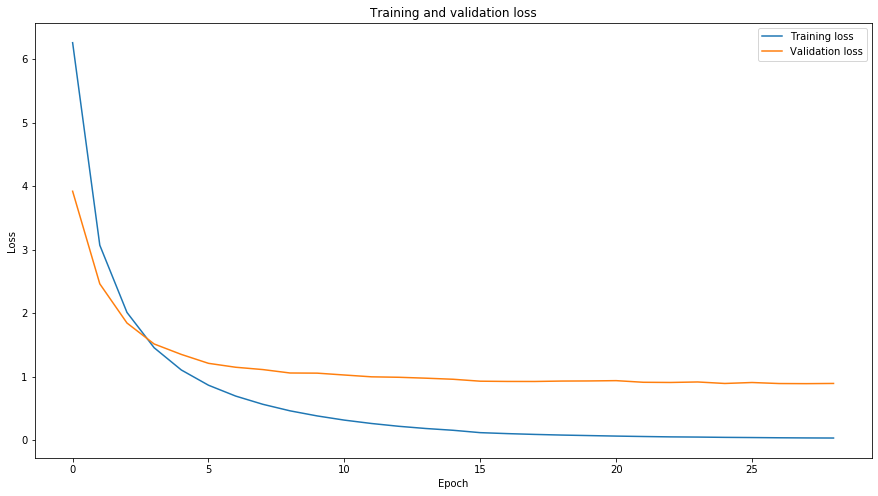

In [14]:
x = [epoch for epoch in range(len(train_loss_history))]
plt.figure(figsize=(15, 8))

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.plot(x, train_loss_history, label='Training loss')
plt.plot(x, val_loss_history, label='Validation loss')

plt.legend()

plt.show()

In [15]:
argmin_val = np.argmin(val_loss_history)
print('Least validation loss: {} in epoch {}'.format(val_loss_history[argmin_val], argmin_val))

Least validation loss: 0.8886258282507893 in epoch 27
